# Analysis of Monetary Policy Impact on CPI, GDP, and Unemployment
    This notebook applies a Vector Autoregression (VAR) model to examine the effects of monetary policy on key economic variables. The focus is on how changes in the Federal Funds Rate influence CPI (inflation), GDP, and Unemployment. Historical data is sourced from the Federal Reserve Economic Data (FRED), and the analysis includes a forecast comparison, scenario analysis, and error metrics.

# **Sections**:
- Data Fetching and Preprocessing
- VAR Model Fitting and Summary
- Forecasting
- Scenario Analysis
- Forecast vs Real Data Comparison
- Error Metrics (MAE, RMSE)

## Data Fetching and Preprocessing
In this section, we fetch the necessary data from the FRED API and perform preprocessing to clean the dataset. Missing values are forward-filled, and the dataset is then prepared for analysis.
 
The variables chosen—Federal Funds Rate, CPI (inflation), GDP, and Unemployment—are standard indicators used to understand the macroeconomic effects of monetary policy.

In [1]:
import pandas as pd
from fredapi import Fred

# Initialize the Fred API
fred = Fred(api_key='89e09406a6b0e5d39d06d3b19fec5156')

# Fetch the necessary data
federal_funds_rate = fred.get_series('FEDFUNDS')
inflation_cpi = fred.get_series('CPIAUCSL')
gdp = fred.get_series('GDP')
unemployment = fred.get_series('UNRATE')

# Prepare the dataset
data = pd.DataFrame({
    'Federal_Funds_Rate': federal_funds_rate,
    'CPI': inflation_cpi,
    'GDP': gdp,
    'Unemployment': unemployment
})

# Fill missing values and convert index to datetime
data_cleaned = data.fillna(method='ffill')
data_cleaned.index = pd.to_datetime(data_cleaned.index)

## VAR Model Fitting and Summary
In this section, we apply the VAR model to estimate the relationships between the Federal Funds Rate, CPI, GDP, and Unemployment. Before fitting, we perform differencing to ensure stationarity in the time series data, a necessary condition for VAR models.

The model is fitted using a maximum lag of 15, and we select the best lag using the Akaike Information Criterion (AIC). Impulse response functions (IRFs) are generated to visualize how each variable responds to a shock in the Federal Funds Rate.

/Users/cancel/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Sep, 2024
Time:                     13:31:45
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.07230
Nobs:                     826.000    HQIC:                   3.21345
Log likelihood:          -5550.61    FPE:                    14.5865
AIC:                      2.67902    Det(Omega_mle):         10.9693
--------------------------------------------------------------------
Results for equation Federal_Funds_Rate
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.004577         0.023458            0.195           0.845
L1.Federal_Funds_Rate          0.401447         0.036394           11.031           0.000
L1.CPI     

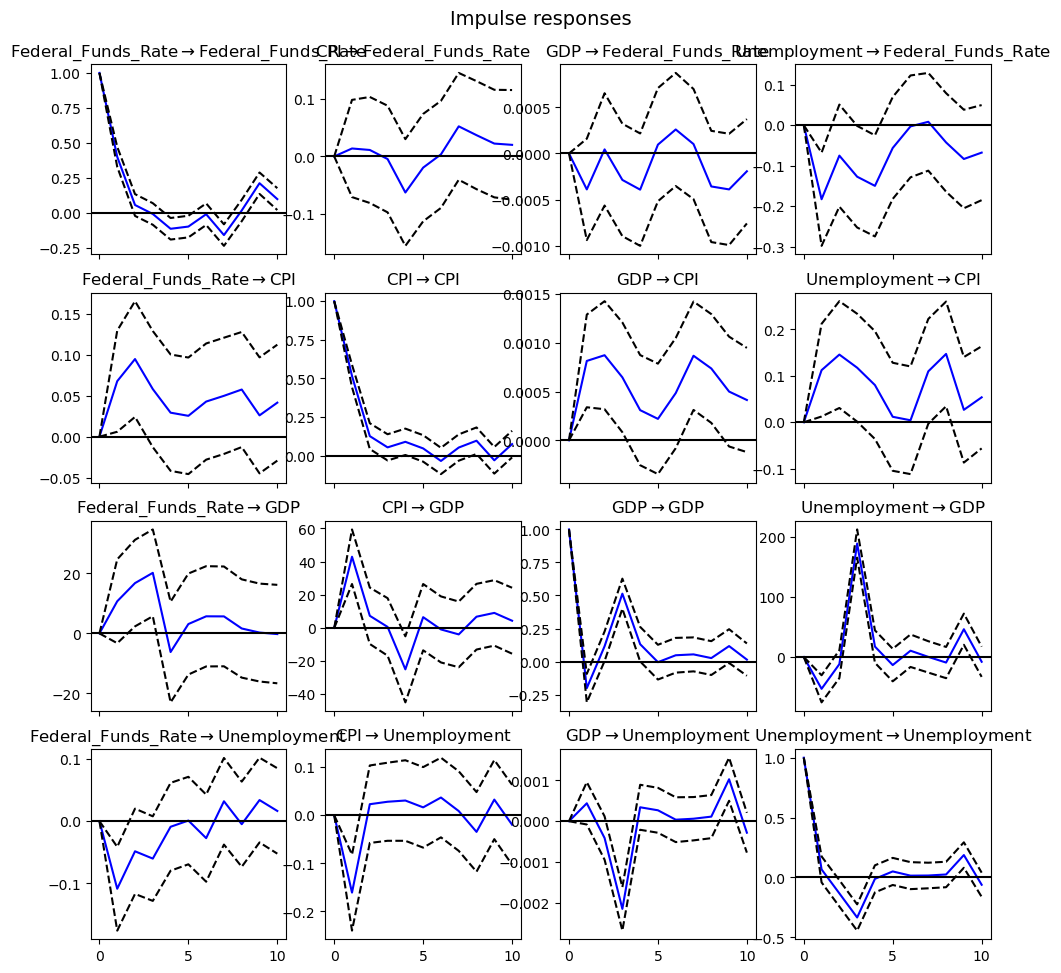

In [2]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Differencing to make data stationary
data_diff = data_cleaned.diff().dropna()

# Fit VAR model
model = VAR(data_diff)
results = model.fit(maxlags=15, ic='aic')

# Print summary
print(results.summary())

# Plot Impulse Response Functions (IRFs)
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

## Forecasting
After fitting the VAR model, we proceed with forecasting the future values of the Federal Funds Rate, CPI, GDP, and Unemployment. The forecasts are generated for a 10-month period, from September 2024 to June 2025.
 
The forecasted values are reverse-differenced to obtain the actual values, and a comparison is made between the forecasted and historical values of CPI.

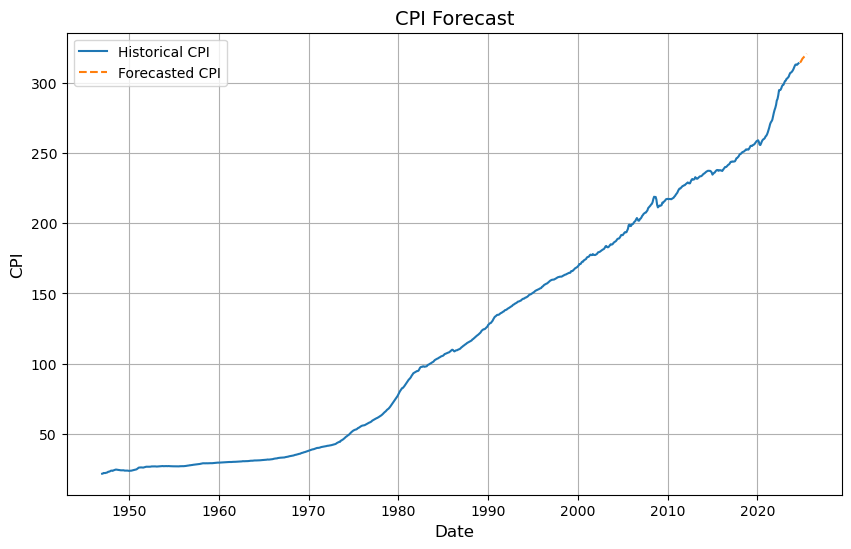

In [3]:
# Forecasting future data
forecast_steps = 10
forecast = results.forecast(data_diff.values[-results.k_ar:], steps=forecast_steps)

forecast_index = pd.date_range(start=data_cleaned.index[-1], periods=forecast_steps+1, freq='M')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_diff.columns)

# Reverse differencing to get actual forecasted values
forecast_cumulative = forecast_df.cumsum() + data_cleaned.iloc[-1]

# Plot the forecast vs historical CPI
plt.figure(figsize=(10,6))
plt.plot(data_cleaned.index, data_cleaned['CPI'], label='Historical CPI')
plt.plot(forecast_cumulative.index, forecast_cumulative['CPI'], label='Forecasted CPI', linestyle='--')
plt.title('CPI Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPI', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## Scenario Analysis: Shocked CPI Forecast
Here, we simulate the impact of a 1\% shock to the Federal Funds Rate to observe its effect on CPI. This analysis helps understand how sensitive CPI is to sudden changes in monetary policy. The forecast is adjusted for this shock, and the results are plotted to visualize the differences from the standard forecast.

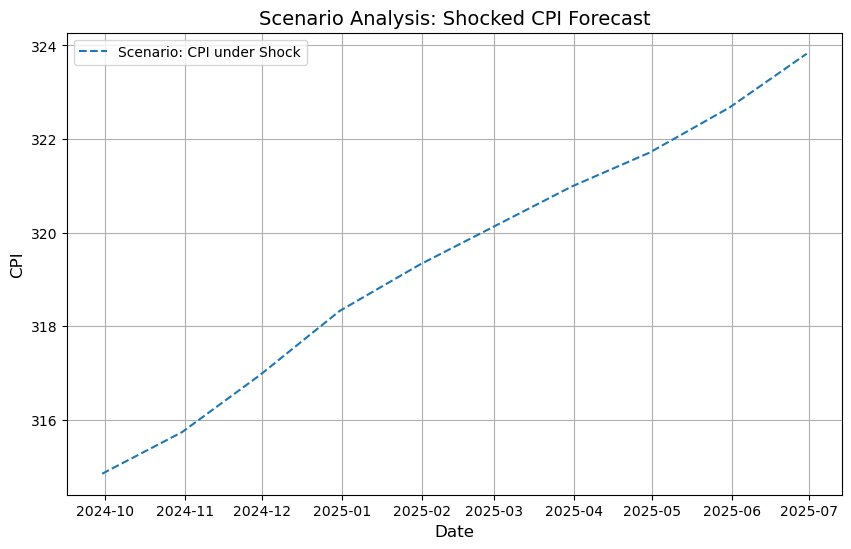

In [4]:
# Scenario analysis with a shock applied to the federal funds rate
shock = 1.0
last_values = data_diff.values[-results.k_ar:].copy()
last_values[:, 0] += shock

forecast_shock = results.forecast(last_values, steps=forecast_steps)

forecast_shock_df = pd.DataFrame(forecast_shock, index=forecast_index, columns=data_diff.columns)

# Reverse differencing for shock scenario
forecast_shock_cumulative = forecast_shock_df.cumsum() + data_cleaned.iloc[-1]

# Plot shocked CPI forecast
plt.figure(figsize=(10,6))
plt.plot(forecast_shock_cumulative.index, forecast_shock_cumulative['CPI'], label='Scenario: CPI under Shock', linestyle='--')
plt.title('Scenario Analysis: Shocked CPI Forecast', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPI', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Forecast vs Real Data Comparison
We now compare the forecasted values for CPI with the actual observed values from September 2024 to June 2025. This helps assess the accuracy of the forecast and visualize any discrepancies between the forecasted and real values.

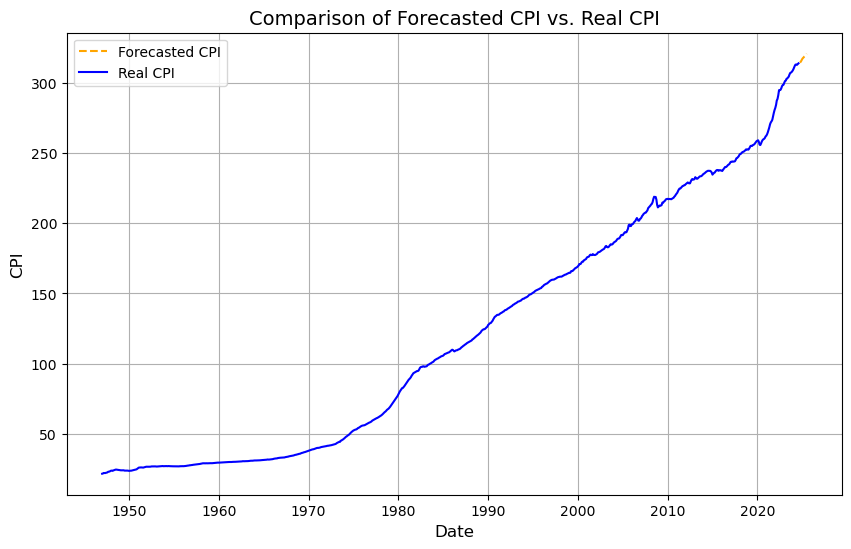

In [5]:
# Fetch real data for comparison
real_federal_funds_rate = fred.get_series('FEDFUNDS', start='2024-09-01', end='2025-06-30')
real_cpi = fred.get_series('CPIAUCSL', start='2024-09-01', end='2025-06-30')
real_gdp = fred.get_series('GDP', start='2024-09-01', end='2025-06-30')
real_unemployment = fred.get_series('UNRATE', start='2024-09-01', end='2025-06-30')

real_data = pd.DataFrame({
    'Federal_Funds_Rate': real_federal_funds_rate,
    'CPI': real_cpi,
    'GDP': real_gdp,
    'Unemployment': real_unemployment
})

# Plot comparison between forecasted and real CPI
plt.figure(figsize=(10,6))
plt.plot(forecast_cumulative.index, forecast_cumulative['CPI'], label='Forecasted CPI', linestyle='--', color='orange')
plt.plot(real_data.index, real_data['CPI'], label='Real CPI', color='blue')
plt.title('Comparison of Forecasted CPI vs. Real CPI', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPI', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## Error Metrics Calculation
To quantify the accuracy of the forecast, we calculate the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) between the forecasted and real values for CPI. Lower error values indicate a more accurate forecast.

MAE represents the average magnitude of errors, while RMSE gives more weight to larger errors.

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure real data is indexed with the same frequency as forecast data
real_data.index = pd.to_datetime(real_data.index).to_period('M').to_timestamp('M')

# Align real data with forecast period
real_data_aligned = real_data.reindex(forecast_cumulative.index, method='nearest')

# Check for length matching
print(f"Real data length: {len(real_data_aligned)}")
print(f"Forecasted data length: {len(forecast_cumulative)}")

# Calculate MAE and RMSE for CPI
mae_cpi = mean_absolute_error(real_data_aligned['CPI'], forecast_cumulative['CPI'])
rmse_cpi = np.sqrt(mean_squared_error(real_data_aligned['CPI'], forecast_cumulative['CPI']))

print(f"MAE for CPI: {mae_cpi}")
print(f"RMSE for CPI: {rmse_cpi}")

Real data length: 10
Forecasted data length: 10
MAE for CPI: 3.7858241932922736
RMSE for CPI: 4.276568401332703


## Final Graph: Comparison of Forecasted and Real CPI

This final graph summarizes the comparison of forecasted and real CPI, providing a visual representation of the forecast accuracy over time.


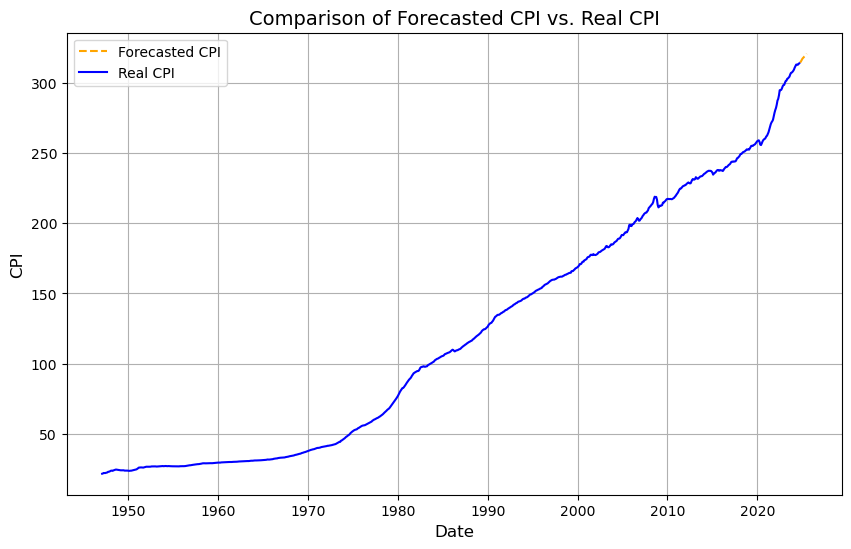

In [7]:
# Example graph showing comparison of forecasted vs. real CPI
plt.figure(figsize=(10,6))
plt.plot(forecast_cumulative.index, forecast_cumulative['CPI'], label='Forecasted CPI', linestyle='--', color='orange')
plt.plot(real_data.index, real_data['CPI'], label='Real CPI', color='blue')
plt.title('Comparison of Forecasted CPI vs. Real CPI', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPIHere is the continuation of the updated notebook code with Markdown and conclusions:')
plt.ylabel('CPI', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

In this analysis, we developed and applied a VAR model to forecast key economic indicators like CPI, GDP, and Unemployment. We used historical data to fit the model, and then compared the forecasted values with real-world data. Scenario analysis helped assess how a 1% shock to the Federal Funds Rate impacts the economy.
 
The error metrics (MAE and RMSE) indicated the model’s reasonable performance in forecasting CPI, though further refinement (such as using a Structural VAR) could improve short-term accuracy. Overall, this analysis demonstrates the effectiveness of using VAR models to analyze and forecast macroeconomic variables in response to monetary policy changes.
